## Problema 5 Lista 4: Diagnóstico por la escritura

Nicolas Llorens Somalo (2023-2024 Q1 APA)

En este problema analizaremos la posibilidad de ofrecer un diagnostico temprano de enfermedades neurodegenerativas mediante de datos recogidos a traves de las escritura de pacientes con un lapiz electronico. El objetivo del problema es distinguir pacientes sanos de pacientes con Alzehimer.

In [3]:
!pip install apafib

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=22ac8b6994a7d98397cf4911e41e2498780a1a0adae2a8cbcfad7ad98d809337
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip


In [4]:
import warnings
from sklearn import set_config
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

### Importacion de los datos

In [5]:
import apafib
raw_data = apafib.load_darwin()
raw_data.head()


,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


Este es un datas set con muchas variables, 452 concretamente por lo que hacer una visualizacion no tiene mucho sentido, asi que empezaremos directamente dividiendo el conjunto de los datos como siempre entre entrenamiento y test (70/30).

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(raw_data, test_size=0.3, random_state=42)

Ahora haremos una primera transformacion de las variables para poder adaptarla a los diferentes modelos que usaremos. Tal y como se explicita en la web de los datos, no hay missing values, pero si hay variables categoricas.Para convertir las variables categoricas usaremos el metodo LabelEncoder de sklearn preprocessing para pasarlas a numericas.

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

raw_data = raw_data.drop(columns=['ID'])
train_data = train_data.drop(columns=['ID'])
test_data = test_data.drop(columns=['ID'])

for column in raw_data.columns:
    if raw_data[column].dtype == 'O':  # Comprobar si la columna es de tipo objeto (categórica)
        train_data[column] = label_encoder.fit_transform(train_data[column])
        test_data[column] = label_encoder.transform(test_data[column])

train_data.head()


,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
69,5400,0.000013,203.749975,206.359195,1427,11100,0.359900,0.197051,205.054585,0.052372,...,0.088991,0.026235,2.895010,3.087367,79,23150,1759.896976,244975.41210,75275,1
36,12960,0.000019,154.094876,66.137920,1335,9809,0.303533,0.168974,110.116398,0.036623,...,0.207932,0.019402,5.171081,2.851422,81,33010,1583.533172,165641.91900,96545,1
85,26050,0.000002,37.102751,113.153186,1319,561,0.180408,0.117720,75.127969,0.028150,...,0.205982,0.018896,4.806361,3.335828,60,35920,1929.296214,94373.02807,59175,1
22,4200,0.000010,123.285345,83.695951,1032,5309,0.239568,0.186360,103.490648,0.024680,...,0.179745,0.023583,5.074789,4.352826,54,30680,1946.490385,110991.86760,59085,1
143,1860,0.000009,470.957208,175.336205,1519,7714,0.960298,0.141992,323.146706,0.179983,...,0.182942,0.020728,4.518016,2.427232,75,30440,1756.927398,122383.35380,57530,0


Ahora marcamos la variable objetivo que es 'class', que indica si el paciente padece Alzehimer o esta sano

### Modelo Base

Como referencia ajustaremos un modelo Naive Bayes para ir comparando su rendimiento con los siguientes modelos

In [8]:
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']

X_test = test_data.drop(columns=['class'])
y_test = test_data['class']


In [9]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

# Entrenar el modelo con los datos de entrenamiento
naive_bayes.fit(X_train, y_train)

# Realizar predicciones en el conjunto de datos de prueba
y_pred = naive_bayes.predict(X_test)

GaussianNB()

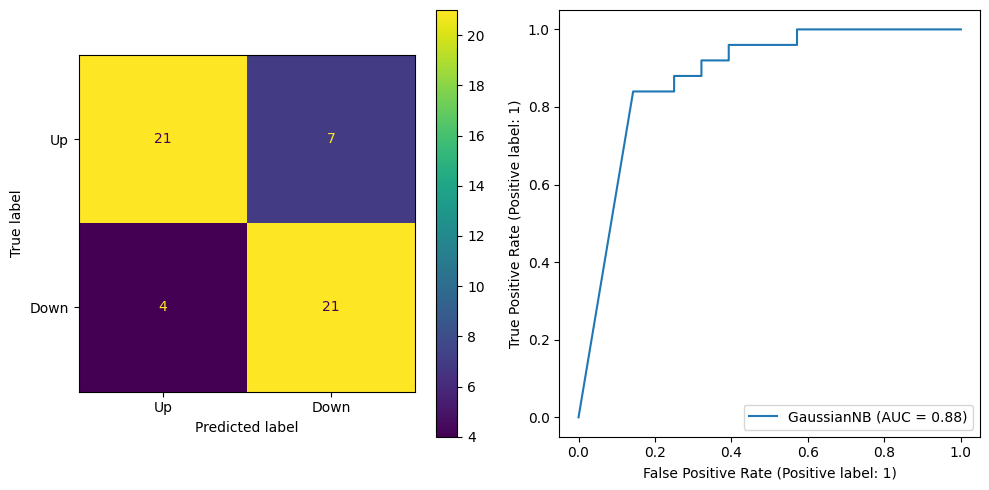

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(naive_bayes, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(naive_bayes, X_test, y_test, ax=ax)
plt.tight_layout()

In [11]:
print("Informe de Clasificación:")
classification_report_naive = classification_report(y_test, y_pred)
print(classification_report_naive)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.75      0.84      0.79        25

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.79        53
weighted avg       0.80      0.79      0.79        53




El modelo parece tener un rendimiento bastante equilibrado tanto para weighted como para macro debido al equilibrio en nuestros datos, con precisión y recall similares para ambas clases. El F1-score también es consistente entre las clases. La precisión global del modelo es del 79%, lo que sugiere que es capaz de clasificar correctamente el 79% de las instancias en el conjunto de datos evaluado. Esto ya es un muy buen resultado pero vamos a ver si podemos mejorarlo.

### SVM

El SVM es un algoritmo ya muy usado en clasificacion de texto por lo que puede ser un buen modelo para nuestros datos. Aun asi, como la gran mayoria de modelos es fuertemente dependiente de los hiperparametros y de los diferentes Kernels. En este caso usaremos un Kernel lineal, polinomico y RBF para ver cual se adapta mejor a nuestro modelo


#### Kernel Lineal

In [12]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear',probability= True)
param_grid_linear = {'C': [0.1, 1, 10, 100]}  # Puedes ajustar estos valores según sea necesario
grid_search_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5)
grid_search_linear.fit(X_train, y_train)
svm_linear_best = grid_search_linear.best_estimator_

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.1, 1, 10, 100]})

Ajustamos un SVM con Kernel Lineal con los mejores hiperparametros gracias a la validacion cruzada usando GridSearchCV. Asi nos aseguramos el mayor rendimiento posible con este Kernel.

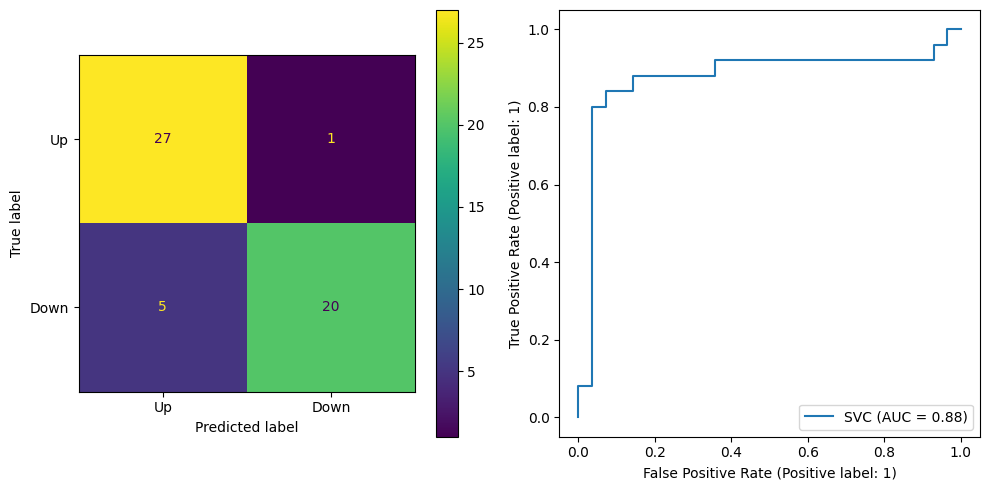

In [13]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(svm_linear_best, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(svm_linear_best, X_test, y_test, ax=ax)
plt.tight_layout()

In [14]:
from sklearn.metrics import classification_report
print("Informe de Clasificación:")
y_pred_svm_linear = svm_linear_best.predict(X_test)
classification_report_svm_linear = classification_report(y_test, y_pred_svm_linear)
print(classification_report_svm_linear)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        28
           1       0.95      0.80      0.87        25

    accuracy                           0.89        53
   macro avg       0.90      0.88      0.88        53
weighted avg       0.89      0.89      0.89        53



Aun teniendo el mismo score de AUC-ROC. El modelo SVM con kernel lineal tiene mejores puntuaciones en precision, recall y F1-score para ambas clases en comparación con Naive Bayes. Esto sugiere que el SVM tiene un rendimiento superior en términos de identificación y clasificación de instancias positivas y negativas.


#### Kernel Polinomico

Ajustamos de nuevo un SVM esta vez con Kernel polinomico y haciendo uso de GridSearchCV para obtener los mejores hiperparametros

In [ ]:
svm_poly = SVC(kernel='poly')
param_grid_poly = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4]}
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5)
grid_search_poly.fit(X_train, y_train)
svm_poly_best = grid_search_poly.best_estimator_

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4]})

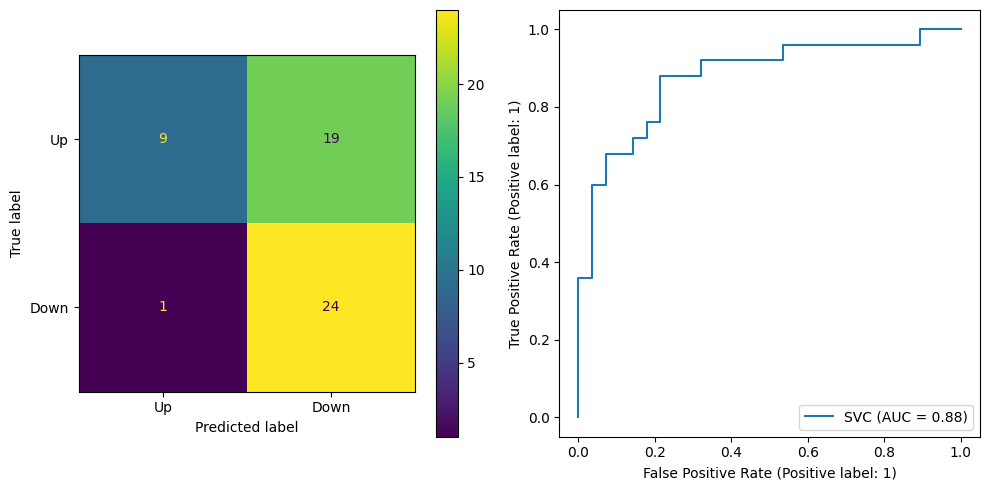

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(svm_poly_best, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(svm_poly_best, X_test, y_test, ax=ax)
plt.tight_layout()

In [ ]:
print("Informe de Clasificación:")
y_pred_svm_poly = svm_poly_best.predict(X_test)
classification_report_svm_poly = classification_report(y_test, y_pred_svm_poly)
print(classification_report_svm_poly)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.32      0.47        28
           1       0.56      0.96      0.71        25

    accuracy                           0.62        53
   macro avg       0.73      0.64      0.59        53
weighted avg       0.74      0.62      0.58        53



Aunque el modelo SVM con Kernel Polinomico tiene el mismo score de AUC ROC que los anteriores modelos, vemos que tiene valores bastante peores (globalmente) en todas las clases (precision, recall y f1-score). Por lo tanto descartamos este modelo.

#### Kernel RBF

Ajustamos de nuevo un SVM esta vez con Kernel RRBF y haciendo uso de GridSearchCV para obtener los mejores hiperparametros

In [ ]:
svm_rbf = SVC(kernel='rbf')
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}
grid_search_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5)
grid_search_rbf.fit(X_train, y_train)
svm_rbf_best = grid_search_rbf.best_estimator_

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001]})

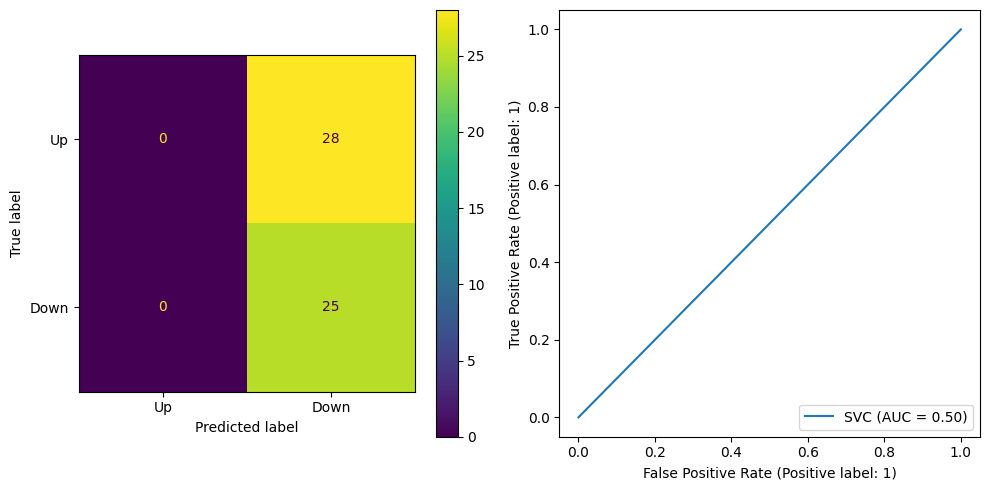

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(svm_rbf_best, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(svm_rbf_best, X_test, y_test, ax=ax)
plt.tight_layout()

In [ ]:
print("Informe de Clasificación:")
y_pred_svm_rbf = svm_rbf_best.predict(X_test)
classification_report_svm_rbf = classification_report(y_test, y_pred_svm_rbf,zero_division=1)
print(classification_report_svm_rbf)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        28
           1       0.47      1.00      0.64        25

    accuracy                           0.47        53
   macro avg       0.74      0.50      0.32        53
weighted avg       0.75      0.47      0.30        53



El AUC-ROC de este modelo ya no indica el funcionamiento realmente malo (0.50 lo consideramos equivalente al rendimiento de un modelo aleatorio). Y vemos esta falta de rendimiento tambien aunque no tanto en precision (cosa que quizas sorprende) pero si en recall y f1-score. Por lo tanto descartamos este modelo.

### Random Forest y Gradient Boosting

#### Random Forest

Ahora ajustaremos un modelo random forest y como hemos hecho antes explorando sus hiperparametros para conseguir el mayor rendimiento.

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
rf_best = grid_search_rf.best_estimator_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

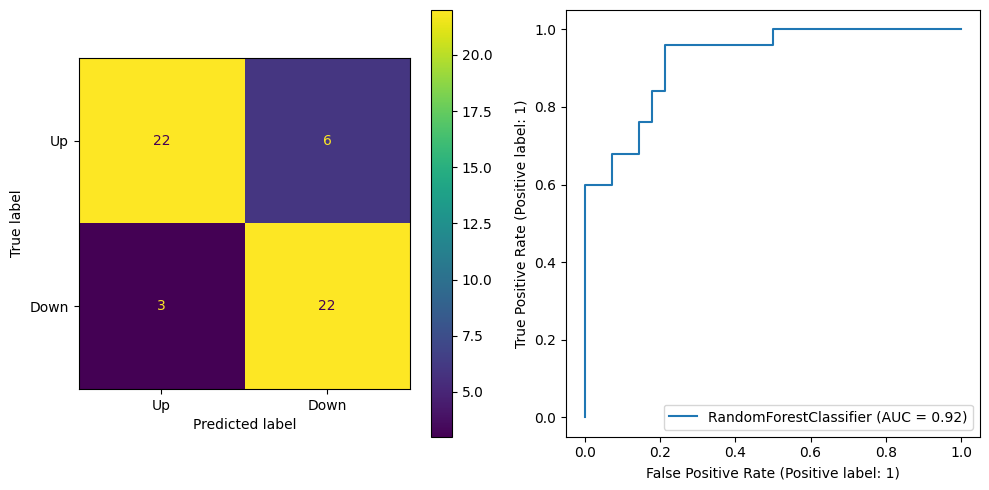

In [16]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(rf_best, X_test, y_test, ax=ax)
plt.tight_layout()

In [17]:
print("Informe de Clasificación:")
y_pred_rf = rf_best.predict(X_test)
classification_report_rf = classification_report(y_test, y_pred_rf,zero_division=1)
print(classification_report_rf)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        28
           1       0.79      0.88      0.83        25

    accuracy                           0.83        53
   macro avg       0.83      0.83      0.83        53
weighted avg       0.84      0.83      0.83        53



Con el AUC ROC vemos un 0.94 lo que es una puntuacion realmente alta, por lo tanto nuestro modelo discrimina aun mejor que Naive Bayes y SVM con Kernel Lineal. Aun asi el modelo SVM tiene un precision global algo mas alta pero Random Forest tiene mejor recall y f1-score. Definitivamente este es un muy buen modelo para estos datos a la par en rendimiento (quizas algo por delante) que el modelo de SVM con Kernel lineal.

#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier()
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=5)
grid_search_gb.fit(X_train, y_train)
gb_best = grid_search_gb.best_estimator_

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

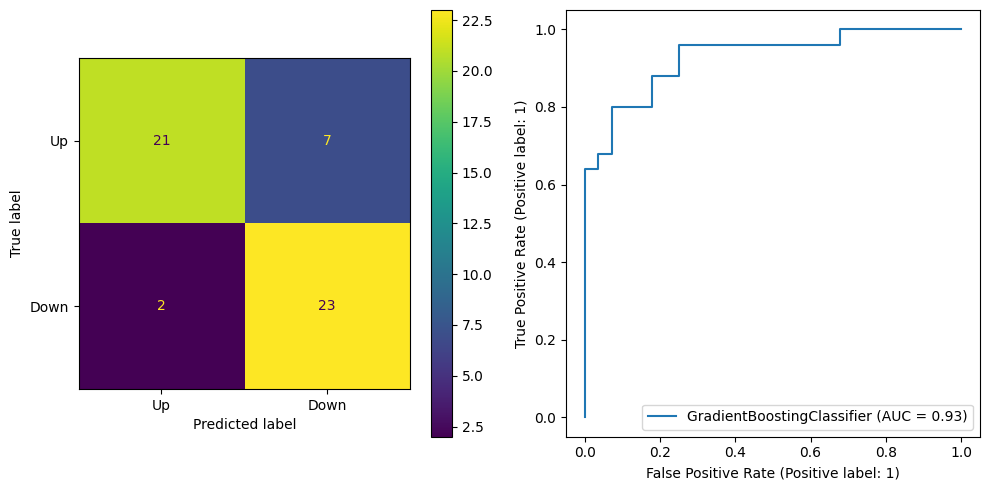

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(gb_best, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(gb_best, X_test, y_test, ax=ax)
plt.tight_layout()

In [ ]:
print("Informe de Clasificación:")
y_pred_gb = gb_best.predict(X_test)
classification_report_gb = classification_report(y_test, y_pred_gb,zero_division=1)
print(classification_report_gb)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        28
           1       0.77      0.92      0.84        25

    accuracy                           0.83        53
   macro avg       0.84      0.83      0.83        53
weighted avg       0.84      0.83      0.83        53



Como vemos este modelo cuenta con un AUC ROC casi identico a Random Forest por lo tanto mantiene un muy buen rendimiento. Y al igual que random forest, la precision es ligeramente mas baja que Naive y el SVM pero recall f1-score si es algo mejor.

### Eleccion de los mejores modelos y entrenamiento de un Voting Classifier

Para un modelo Voting Classifier lo que buscamos es incluir modelos diversos y con diferentes enfoques para que las fortalezas de uno compensen los puntos debiles de otro. Dicho esto, escoger entonces dos modelos entre SVM, Random Forest y Gradient Boosting es dificil en terminos de rendimiento y cualquiera es una eleccion valida, lo ideal, es probar los rendimientos de todas las combincaciones, pero en este caso escogere Naive Bayes, Random Forest y SVM.No he escogido gradient boosting debido a que espero mantener el AUC-ROC gracias al Random Forest pero sobretodo mantener precision, recall y f1-score gracias a Naive Bayes y el SVM Lineal.

In [19]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[
        ('naive_bayes', naive_bayes),
        ('random_forest', rf_best),
        ('SVM_Lineal', svm_linear_best)
    ],
    voting='soft'
)

voting_classifier.fit(X_train, y_train)



VotingClassifier(estimators=[('naive_bayes', GaussianNB()),
                             ('random_forest',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=50)),
                             ('SVM_Lineal',
                              SVC(C=0.1, kernel='linear', probability=True))],
                 voting='soft')

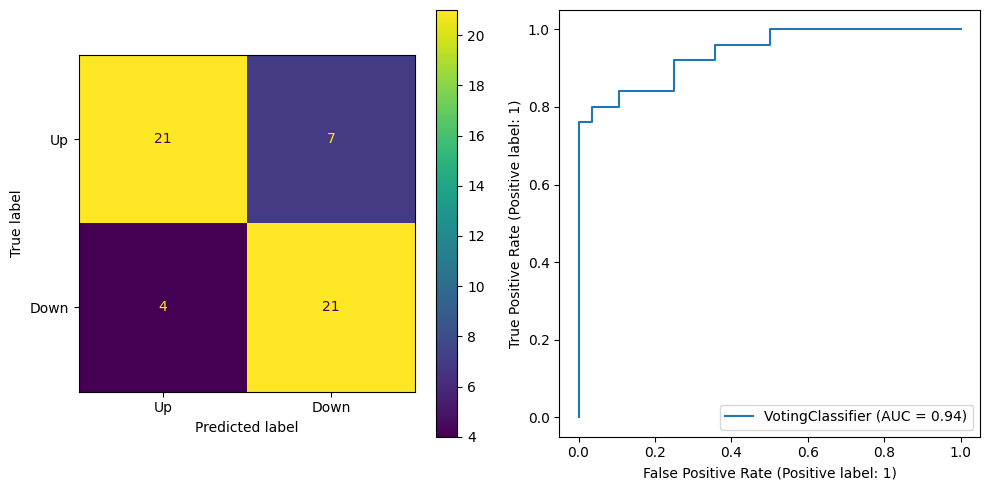

In [20]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(voting_classifier, X_test, y_test, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(voting_classifier, X_test, y_test, ax=ax)
plt.tight_layout()

In [21]:
print("Informe de Clasificación:")
y_pred_voting = voting_classifier.predict(X_test)
classification_report_voting = classification_report(y_test, y_pred_voting,zero_division=1)
print(classification_report_voting)


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.75      0.84      0.79        25

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.79        53
weighted avg       0.80      0.79      0.79        53



### Conclusiones

Como podemos ver, el voting classifier consigue un AUC-ROC muy bueno pero no mejora en ninguna metrica de clasificacion (se queda con una parecida a la del Random Forest). En conclusion, un voting classifier, puede funcionar muy bien, y mas para la cantidad de variables que tiene nuestro problema pero quizas (aunque no se pida en el enunciado) sería interesante combinar mas modelos (o combinarlos todos) para obtener esa mejora de rendimiento. También puede ser que no haya mejorado el rendimiento debido a la similitud entre modelos, quizás un Gradient Boosting se hubiese alejado mas en funcionamiento de los que he escogido y complementaría en VotingClassifier. En definitiva, como en toda la asignatura de APA, a medida que vamos entrenando modelos, vamos sacando nuevas hipotesis que pueden mejorar nuestras métricas y es cuestión de ir probando.

Aun asi, las metricas son realmente buenas y la mayoria de modelos han dado muy buenos resultados.